# Lending Club - Case Study

### Import and Prep the data

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Reading the input data (csv)

In [2]:
loan = pd.read_csv('loan.csv', header=0)

loan.shape

(39717, 111)

#### Initial Analysis

- The Data contains 38717 Records and 111 rows. 
- The data contains many columns which have only 1 unique value in the entire dataset. These columns may not be useful..

In [3]:
### Columns that have only 1 value in the dataset. They doesn't help us in the analysis and can be ignored.
for col in loan.columns:
    if(len(loan[col].unique()) == 1) :
        print(col)

columns_to_work = loan.columns[loan.apply(lambda x: len(x.unique()) > 1)].tolist()
loan = loan.loc[:, columns_to_work]
loan.info()

# to verify if the changes are implied.
# loan.columns[loan.apply(lambda x: len(x.unique()) == 1)]

pymnt_plan
initial_list_status
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 t

- The requested Loan Amount is listed in the column **loan_amnt**
- The Loan amount suggested by the Lending Club at the time of loan issuance is listed in the column **funded_amnt**
- The Loan approved by the investor authority (final loan amount is mentioned in the **funded_amnt_inv**)
- The column **term** represents the tenure of the Loan. We have only 2 values here 36 months and 60 months. - *TODO:* clean the data to make it an integer.
- The loan issue date is represented in the column **issue_d**. It has missing day column. - *TODO:* Convert this to a DateTime and extract the year and month details. 
- The interest rate of the loan approved is mentioned in the **int_rate** column - *TODO:* Clean the data by removing the % so as we can use it for bucketted analysis.
- The **installment** column represents the monthly installments to be paid against the loan.
- The **grade** and **sub-grade** are the internal categories assigned by the Lending Club. May be used to differentiate certain entries. 

- The column **emp_title** has incomplete information. However, if we can filter down the empty values, we may observe a patten.
- The column **emp_length** has inadequate data;

- The column **home_ownership** is an important attribute and can be analyzed to identify a correlation across the defaulters.
- The column **annual_inc** has annual incomes and can be used for analysis to identify how it is impacting the defaulters.
- The column **verification_status** has background verification status; an important attribute which can identify the defaulters.
- The column **issue_d** is the loan issued date. We can extract the information of month and year from it. 
- The column **loan_status** signifies if the loan is fully paid/current/charged off. It may not make any sense to analyze the loans in current status. Hence, we can filter it out and compare the rest. 
- The column **pymnt_plan** has unique value 'n' across the data set; Hence it can be ignored. 
- The column **url**, desc are not useful for our current analysis; Hence, can be ignored. 
- The column **purpose** serves as an good categorical variable for our analysis.
- The column **title** may be a title of the loan application and may not be a good candidate for analysis.
- The column **zip_code**, state may be used to extract the impact demographics over the possibility of defaulting.
- The column **dti** - Debit to Income, could be an important factor as it determines the economic potential of the member.
- The column **pub_rec_bankruptcies** may help us identify the previous bankruptcies.


#### Check if any columns are null or has invalid data

In [4]:
loan.columns.isnull().any()

False

In [5]:
loan.columns.isna().any()

False

In [6]:
# Convert term data to numeric

loan['term'] = loan.term.apply(lambda x: int(x.replace(' months','')))
# loan.term.head()

# Convert the Interest Rate Column
loan['int_rate'] = loan.int_rate.apply(lambda x: float(x.replace('%', '')))
# loan.int_rate.head()

# loan.head()

In [7]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  int64  
 6   int_rate                    39717 non-null  float64
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [8]:
#from datetime import datetime
#loan.issue_d.apply(lambda x: datetime.strptime(x, '%b-%y'))

#loan.issue_d.DatetimeIndex.strftime('%b-%y')
loan.issue_d = pd.to_datetime(loan.issue_d, format='%b-%y')
loan.last_pymnt_d = pd.to_datetime(loan.last_pymnt_d, format='%b-%y')
loan.next_pymnt_d = pd.to_datetime(loan.next_pymnt_d, format='%b-%y')
loan.last_credit_pull_d = pd.to_datetime(loan.last_credit_pull_d, format='%b-%y')

In [9]:
# Clean the data: term   Obj-> float
# Clean the data: int_rate  Obj-> float
# Convert to Date: issue_d  Obj-> date
loan.rename(columns={'issue_d' : 'issue_date', 'last_pymnt_d' : 'last_payment_date', 'next_pymnt_d' : 'next_payment_date', 'last_credit_pull_d' : 'last_credit_pull_date'}, inplace=True)
loan.rename(columns={'loan_amnt' : 'loan_amount', 'funded_amnt': 'funded_amount', 'funded_amnt_inv': 'funded_amount_investor', 'int_rate': 'interest_rate'}, inplace=True)

loan.rename(columns={'open_acc' : 'open_credit_lines', 'pub_rec' : 'public_derogatory_records', 'revol_bal' : 'credit_revolving_balance', 'revol_util' : 'credit_revolving_utilization_rate', 'total_acc' : 'total_credit_accounts', 'out_prncp' : 'outstanding_principal', 'out_prncp_inv' : 'outstanding_principal_investor'}, inplace=True)
loan.rename(columns={'total_pymnt' : 'total_payment_received', 'total_pymnt_inv' : 'total_payment_received_investor_fund', 'total_rec_prncp' : 'total_received_principal', 'total_rec_int' : 'total_received_interest', 'total_rec_late_fee' :'total_received_late_fee', 'last_pymnt_amnt' : 'last_payment_amount'}, inplace=True)

# Add columns for Issue year and month for analysis
loan['issue_year'] = pd.DatetimeIndex(loan.issue_date).year
loan['issue_month'] = pd.DatetimeIndex(loan.issue_date).month

# loan.info()

In [10]:
# Clean the column emp_length

def convert_emp(x):
    if(x=='< 1 year'):
        return 0
    elif(x=='1 year'):
        return 1
    elif(x=='10+ years'):
        return 10
    elif(type(x) == str):
        return x.replace(' years', '')
    else:
        return np.nan

loan['emp_length'] = loan.emp_length.apply(lambda x: convert_emp(x))

In [11]:
# calculate the mean emp length
mean_emp_length = round(loan[-loan.emp_length.isna()].emp_length.apply(lambda x: int(x)).mean())
#mean_emp_length = round(loan[-loan.emp_length.isna()].emp_length.apply(lambda x: int(x)).median())
loan[loan.emp_length.isna()] = loan[loan.emp_length.isna()].apply(lambda x: mean_emp_length)
loan.emp_length = loan.emp_length.apply(lambda x: int(x))

# Verify the cleaned data.
#loan.emp_length.unique()


In [12]:
loan.emp_length.info()

<class 'pandas.core.series.Series'>
RangeIndex: 39717 entries, 0 to 39716
Series name: emp_length
Non-Null Count  Dtype
--------------  -----
39717 non-null  int64
dtypes: int64(1)
memory usage: 310.4 KB


In [13]:
# Filterout the loan_status = 'Current' as it is an active/on-going loan
non_current_loans = loan[loan.loan_status != 'Current']
non_current_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38619 entries, 0 to 39716
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    38619 non-null  int64  
 1   member_id                             38619 non-null  int64  
 2   loan_amount                           38619 non-null  int64  
 3   funded_amount                         38619 non-null  int64  
 4   funded_amount_investor                38619 non-null  float64
 5   term                                  38619 non-null  int64  
 6   interest_rate                         38619 non-null  float64
 7   installment                           38619 non-null  float64
 8   grade                                 38619 non-null  object 
 9   sub_grade                             38619 non-null  object 
 10  emp_title                             37211 non-null  object 
 11  emp_length     

### Identify the Data

In [14]:
#Continuous Columns in the data
continuous_columns = ['loan_amount', 'funded_amount', 'funded_amount_investor', 'interest_rate', 'installment', 'emp_length', 'inq_last_6mths', 'dti', 'credit_revolving_balance', 'credit_revolving_utilization_rate', 'outstanding_principal', 'outstanding_principal_investor', 'total_payment_received_investor_fund', 'total_received_principal', 'total_received_interest', 'total_received_late_fee', 'last_payment_amount']
categorical_columns = ['term', 'grade', 'sub_grade', 'emp_title', 'verification_status', 'loan_status', 'purpose', 'zip_code', 'issue_year', 'issue_month']

#### Univariate Analysis

<AxesSubplot:xlabel='term', ylabel='Count'>

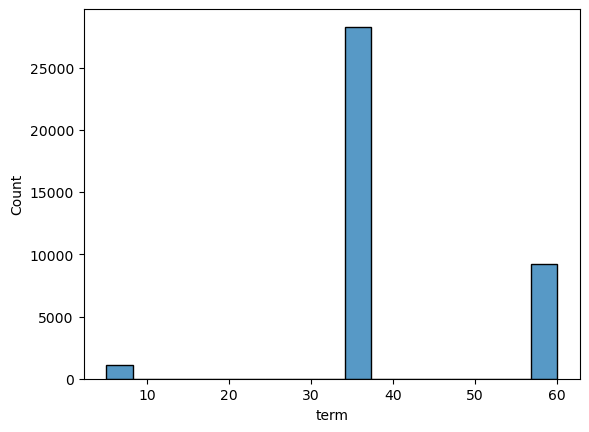

In [15]:
sns.histplot(data=non_current_loans, x='term')

In [16]:
loan.policy_code

AttributeError: 'DataFrame' object has no attribute 'policy_code'

#### Find the loans defaulted

In [ ]:
loan.loan_status.unique()

In [ ]:
defaulted_loans = loan[loan.loan_status == 'Charged Off']
defaulted_loans = defaulted_loans[['loan_amnt', 'purpose', 'dti', 'zip_code', 'addr_state', 'emp_length', 'policy_code']]
defaulted_loans.info()

In [ ]:
defaulted_loans[['loan_amnt', 'purpose', 'dti', 'zip_code', 'addr_state', 'emp_length', 'policy_code']]
defaulted_loans.head()

In [ ]:
numerical_col = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee']
categorical_col = ['purpose', 'zip_code', 'installment', 'policy_code', 'home_ownership', 'application_type']

In [ ]:
for col in loan.columns:
    if(len(loan[col].unique()) > 1) :
        print(col)

In [ ]:
len(loan.application_type.unique())

In [ ]:
loan.groupby(by='id').info()